<a href="https://colab.research.google.com/github/Oksana0020/DL-with-PyTorch/blob/main/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image & Text Classification in PyTorch

In [3]:
!pip uninstall -y torch torchvision torchtext
!pip install torch==2.3.0 torchvision==0.18.0 torchtext==0.18.0 --index-url https://download.pytorch.org/whl/cpu

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Found existing installation: torch 2.3.0+cpu
Uninstalling torch-2.3.0+cpu:
  Successfully uninstalled torch-2.3.0+cpu
Found existing installation: torchvision 0.18.0+cpu
Uninstalling torchvision-0.18.0+cpu:
  Successfully uninstalled torchvision-0.18.0+cpu
Found existing installation: torchtext 0.18.0+cpu
Uninstalling torchtext-0.18.0+cpu:
  Successfully uninstalled torchtext-0.18.0+cpu
Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.3.0%2Bcpu-cp312-cp312-linux_x86_64.whl (190.4 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.18.0%2Bcpu-cp312-cp312-linux_x86_64.whl (1.6 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchtext-0.18.0%2Bcpu-cp312-cp312-linux_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.9.0+cpu requires torch==2.9

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset
trainset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# DataLoader
trainloader = DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

print("Trainloader ready:", len(trainloader))


Trainloader ready: 938


CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch [1/3] - Training Loss: 0.4665


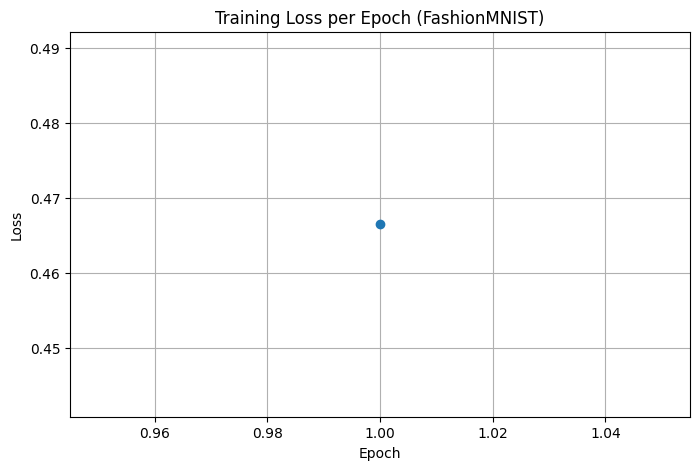

Epoch [2/3] - Training Loss: 0.3035


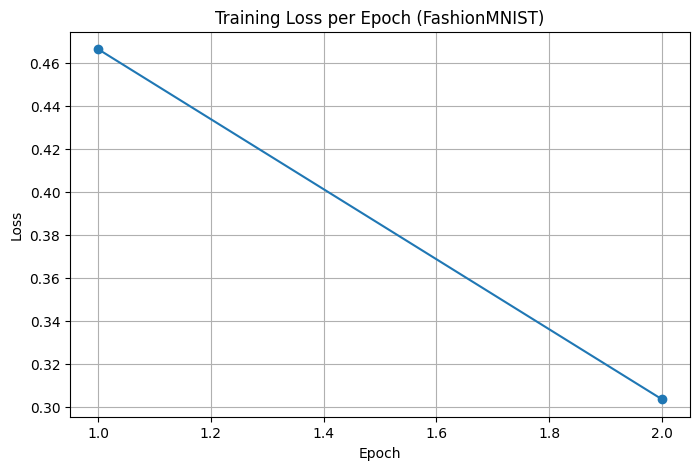

Epoch [3/3] - Training Loss: 0.2585


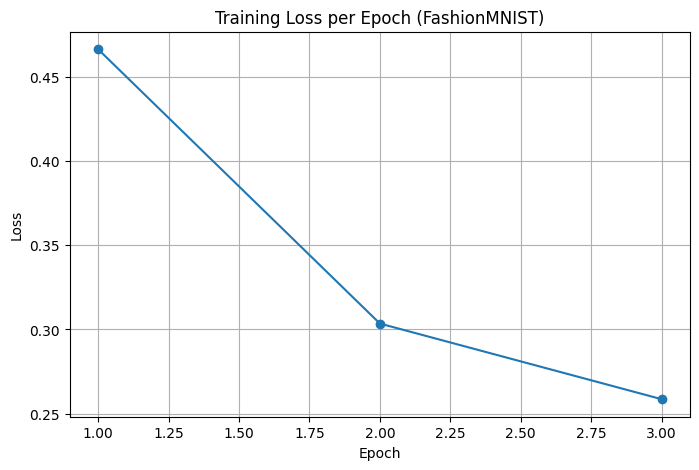

In [11]:
# Define model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 28x28 -> 28x28

        # ReLU activation (we'll use it in forward)
        self.relu = nn.ReLU()

        # Max pooling (halves H and W)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14 (after first pool), then 7x7

        # Dropout layer (helps reduce overfitting)
        self.dropout = nn.Dropout(0.25)

        # Two fully connected layers
        # After two pools: 28x28 -> 14x14 -> 7x7, with 64 channels
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 FashionMNIST classes

    def forward(self, x):
        # Conv block 1: Conv -> ReLU -> Pool
        x = self.pool(self.relu(self.conv1(x)))

        # Conv block 2: Conv -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # FC block: FC -> ReLU -> Dropout -> FC
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # logits (no softmax needed for CrossEntropyLoss)

        return x

model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)


# Training loop (it was requested to trainfor at least 3 epochs)
epochs = 3
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {avg_loss:.4f}")
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
    plt.title("Training Loss per Epoch (FashionMNIST)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


Tests

In [12]:
### BEGIN TESTS
assert isinstance(model, nn.Module), "model should be an instance of nn.Module"

print("✅ TEST PASSED!")

✅ TEST PASSED!


In [5]:
### BEGIN  TESTS
conv_layers = [m for m in model.modules() if isinstance(m, nn.Conv2d)]
assert len(conv_layers) == 2, "Model must include two nn.Conv2d layers"
print("✅ TEST PASSED!")

✅ TEST PASSED!


In [6]:
### BEGIN  TESTS
assert isinstance(model.dropout, nn.Dropout), "Dropout should be nn.Dropout"
print("✅ TEST PASSED!")

✅ TEST PASSED!


In [7]:
# Training loop
train_losses = []
for epoch in range(3):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulatebatch
        running_loss += loss.item()

    # Average loss for the epoch
    avg_epoch_loss = running_loss / len(trainloader)
    train_losses.append(avg_epoch_loss)

    print(f"Epoch {epoch+1}/3 - Loss: {avg_epoch_loss:.4f}")

Epoch 1/3 - Loss: 0.2279
Epoch 2/3 - Loss: 0.2070
Epoch 3/3 - Loss: 0.1825


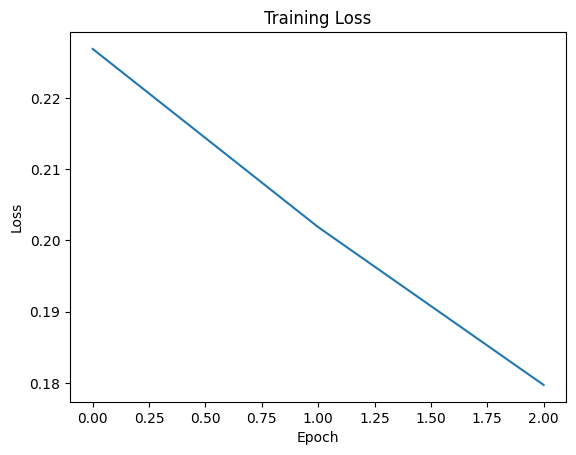

In [8]:
# Plot loss
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

some tests

In [8]:
### BEGIN  TESTS
assert isinstance(train_losses, list), "train_losses should be a list"
print("✅ TEST PASSED!")

✅ TEST PASSED!


In [9]:
### BEGIN  TESTS
assert len(train_losses) >= 3, "Should track loss for at least 3 epochs"
print("✅ TEST PASSED!")

✅ TEST PASSED!


In [10]:
### BEGIN  TESTS
assert train_losses[-1] < train_losses[0] or abs(train_losses[-1] - train_losses[0]) < 0.1, "Training loss should generally decrease"
print("✅ TEST PASSED!")

✅ TEST PASSED!


Task 2

In [15]:
import torch
import torchtext
print("torch:", torch.__version__)
print("torchtext:", torchtext.__version__)
from torchtext.datasets import IMDB


torch: 2.3.0+cpu
torchtext: 0.18.0+cpu


In [22]:
import torch
import random
import torchtext
torchtext.disable_torchtext_deprecation_warning()

from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


In [26]:
!pip -q install datasets

import torch
import random
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ds = load_dataset("imdb")

# ds["train"] has fields: {"text": ..., "label": 0/1}
train_list = list(zip(
    ["pos" if y == 1 else "neg" for y in ds["train"]["label"]],
    ds["train"]["text"]
))
test_list = list(zip(
    ["pos" if y == 1 else "neg" for y in ds["test"]["label"]],
    ds["test"]["text"]
))

random.seed(42)
train_data = random.sample(train_list, 2000)
test_data  = random.sample(test_list, 2000)

train_data, valid_data = train_data[:1600], train_data[1600:]

print(len(train_data), len(valid_data), len(test_data))
print(train_data[0][0], train_data[0][1][:80])


Using device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

1600 400 2000
pos Arguably this is a very good "sequel", better than the first live action film 10


In [27]:
# Tokenizer
tokenizer = get_tokenizer('basic_english')

# Build vocabulary
def yield_tokens(data):
    for label, text in data:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=['<unk>', '<pad>'], max_tokens=10000)
vocab.set_default_index(vocab['<unk>'])

In [28]:
# Data pipeline
def text_pipeline(text):
    return vocab(tokenizer(text))


def collate_batch(batch):
    labels = []
    sequences = []
    lengths = []

    pad_idx = vocab['<pad>']

    for label, text in batch:
        # Label is "pos" or "neg" in torchtext IMDB
        lbl = 1.0 if label == 'pos' else 0.0
        labels.append(lbl)

        seq = text_pipeline(text)
        seq_tensor = torch.tensor(seq, dtype=torch.long)
        sequences.append(seq_tensor)
        lengths.append(len(seq))

    max_len = max(lengths) if lengths else 0
    padded_sequences = torch.full((len(sequences), max_len), pad_idx, dtype=torch.long)
    for i, seq_tensor in enumerate(sequences):
        padded_sequences[i, :seq_tensor.size(0)] = seq_tensor
    lengths = torch.tensor(lengths, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.float32)
    return padded_sequences.to(device), lengths.to(device), labels.to(device)


In [30]:
from torch.cuda.amp import GradScaler, autocast


In [31]:
# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, collate_fn=collate_batch)

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, output_dim, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            lengths.detach().cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        packed_out, (hidden, cell) = self.lstm(packed)
        last_hidden = hidden[-1]  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)
        return logits.squeeze(1)  # (batch_size,)

model = LSTMClassifier(len(vocab), 100, 256, 1, pad_idx=vocab['<pad>']).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

# Initialize GradScaler
scaler = GradScaler(enabled=device.type == "cuda")

Tests

In [32]:
### BEGIN   TESTS
params = list(model.parameters())
assert len(params) > 0, "Model must have trainable parameters"
print("✅ TEST PASSED!")

✅ TEST PASSED!


In [33]:
### BEGIN   TESTS
assert callable(model.forward), "Model must implement a forward method"
print("✅ TEST PASSED!")

✅ TEST PASSED!


In [35]:
train_losses, valid_losses = [], []

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    # ---------- TRAIN ----------
    model.train()
    running_train_loss = 0.0

    for x, lengths, y in train_loader:
        optimizer.zero_grad()

        logits = model(x, lengths)          # forward
        loss = criterion(logits, y)          # loss

        loss.backward()                      # backward
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(float(avg_train_loss))

    # ---------- VALIDATE ----------
    model.eval()
    running_valid_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for x, lengths, y in valid_loader:
            logits = model(x, lengths)
            loss = criterion(logits, y)
            running_valid_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct += (preds == y).sum().item()
            total += y.numel()

    avg_valid_loss = running_valid_loss / len(valid_loader)
    valid_losses.append(float(avg_valid_loss))
    valid_acc = 100.0 * correct / total

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
        f"- Train Loss: {avg_train_loss:.4f} "
        f"| Valid Loss: {avg_valid_loss:.4f} "
        f"| Valid Acc: {valid_acc:.2f}%"
    )


Epoch [1/10] - Train Loss: 0.6157 | Valid Loss: 0.6496 | Valid Acc: 63.00%
Epoch [2/10] - Train Loss: 0.5357 | Valid Loss: 0.8058 | Valid Acc: 62.50%
Epoch [3/10] - Train Loss: 0.4699 | Valid Loss: 0.7497 | Valid Acc: 64.50%
Epoch [4/10] - Train Loss: 0.3592 | Valid Loss: 0.7700 | Valid Acc: 67.25%
Epoch [5/10] - Train Loss: 0.2564 | Valid Loss: 0.7870 | Valid Acc: 68.75%
Epoch [6/10] - Train Loss: 0.1614 | Valid Loss: 0.9452 | Valid Acc: 71.00%
Epoch [7/10] - Train Loss: 0.1003 | Valid Loss: 1.0086 | Valid Acc: 71.50%
Epoch [8/10] - Train Loss: 0.0688 | Valid Loss: 1.1365 | Valid Acc: 69.00%
Epoch [9/10] - Train Loss: 0.0353 | Valid Loss: 1.2067 | Valid Acc: 72.00%
Epoch [10/10] - Train Loss: 0.0294 | Valid Loss: 1.4398 | Valid Acc: 69.25%


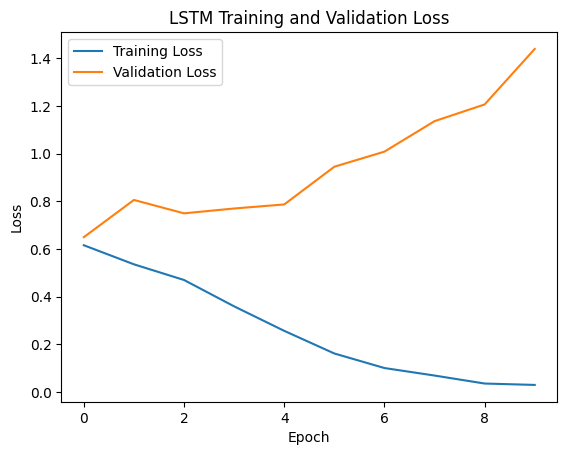

In [36]:
# Plot losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title("LSTM Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Tests

In [1]:
### BEGIN   TESTS
assert isinstance(train_losses, list), "train_losses should be a list"
print("✅ TEST PASSED!")

NameError: name 'train_losses' is not defined

In [38]:
### BEGIN   TESTS
assert all(isinstance(l, float) for l in train_losses), \
       "Training losses must be numeric"
print("✅ TEST PASSED!")

✅ TEST PASSED!
